<a href="https://colab.research.google.com/github/EX1cyclone/635_project_pollution_detect/blob/main/CNN_LTSM%2CCNN%2CLTSM%2Cfinal_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

# Load dataset
file_path = '/content/PRSA_Data_Aotizhongxin_20130301-20170228.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Handling missing values with linear spline interpolation
data.interpolate(method='linear', inplace=True)

# Encode categorical variables (Example: Wind Direction)
# Replace 'wind_direction_column' with your actual column name
if 'wind_direction_column' in data.columns:
    data['wind_direction_encoded'] = data['wind_direction_column'].apply(lambda x: ... )  # Define your encoding logic

# Normalize PM2.5 concentration and other features
scaler = MinMaxScaler()
data['PM2.5_normalized'] = scaler.fit_transform(data[['PM2.5']])  # Replace 'PM2.5' with your actual column name

# Feature selection using Pearson correlation
correlation_threshold = 0.5  # Define your correlation threshold
correlation_matrix = data.corr()
features = correlation_matrix.index[abs(correlation_matrix["PM2.5_normalized"]) > correlation_threshold]

# Selected features dataset
selected_data = data[features]


<ipython-input-1-fb02b2488dd4>:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


print(data.columns)



Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station',
       'PM2.5_normalized'],
      dtype='object')


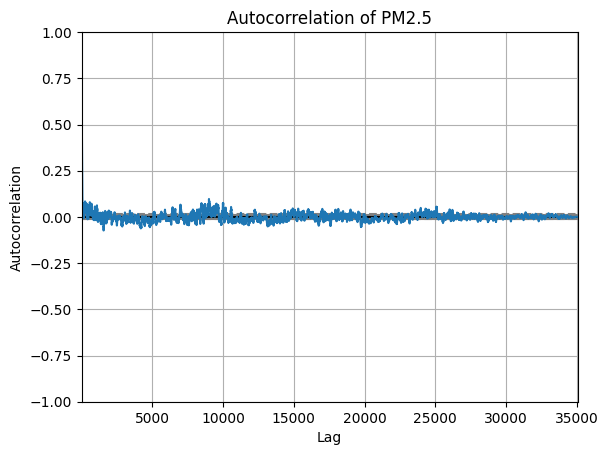

In [ ]:
from pandas.plotting import autocorrelation_plot

# Plot autocorrelation for PM2.5
autocorrelation_plot(data['PM2.5'].dropna())
plt.title('Autocorrelation of PM2.5')
plt.show()


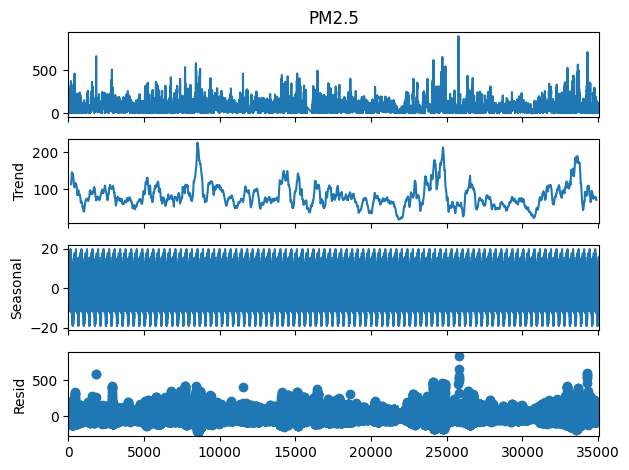

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series data
decomposition = seasonal_decompose(data['PM2.5'].dropna(), model='additive', period=365)

# Plot the decomposed components
decomposition.plot()
plt.show()


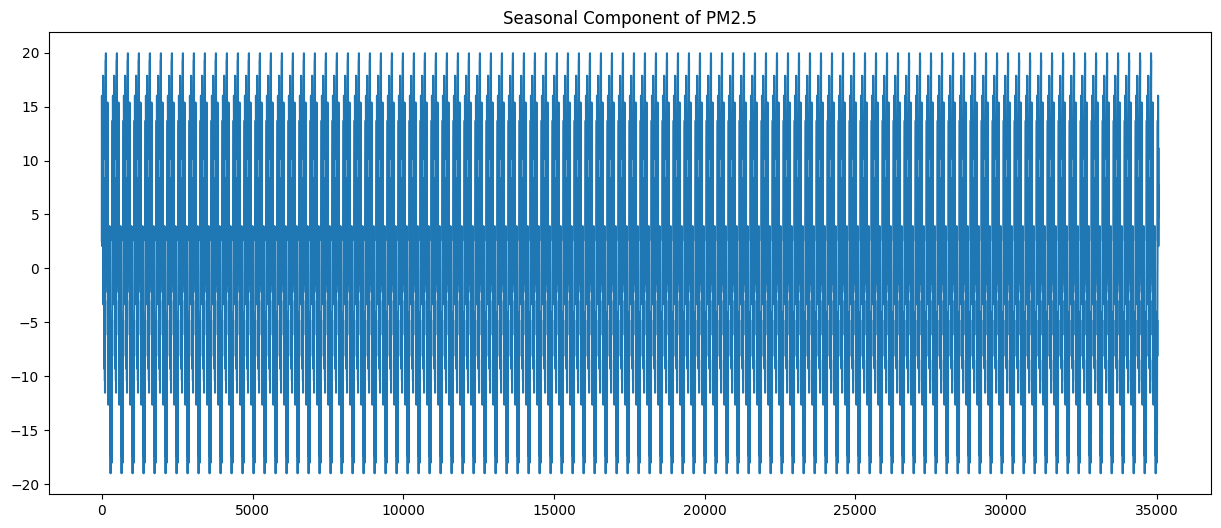

In [ ]:
# Continue from the decomposition step
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the seasonal component
seasonal.plot(figsize=(15, 6))
plt.title('Seasonal Component of PM2.5')
plt.show()


In [ ]:
# Re-importing MinMaxScaler as it seems it was not recognized in the previous cell
from sklearn.preprocessing import MinMaxScaler

# Redefining the encoding function for wind direction
def encode_wind_direction(wd):
    wind_directions = {
        'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
        'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
        'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
        'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
    }
    return wind_directions.get(wd, np.nan)  # Return NaN for unknown directions

# Apply the encoding to the wind direction column
data['wind_direction_encoded'] = data['wd'].apply(encode_wind_direction)

# Handle missing values with linear spline interpolation
data.interpolate(method='linear', inplace=True)

# Normalize PM2.5 concentration and other features
scaler = MinMaxScaler()
data['PM2.5_normalized'] = scaler.fit_transform(data[['PM2.5']])

# Feature selection using Pearson correlation
correlation_threshold = 0.5  # Define your correlation threshold
correlation_matrix = data.corr()
features = correlation_matrix.index[abs(correlation_matrix["PM2.5_normalized"]) > correlation_threshold]

# Create a dataset with selected features
selected_data = data[features]

# Display the first few rows of the updated dataset
selected_data.head()


<ipython-input-3-eeb3256b7c5b>:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


,PM2.5,PM10,NO2,CO,PM2.5_normalized
0,4.0,4.0,7.0,300.0,0.001117
1,8.0,8.0,7.0,300.0,0.005587
2,7.0,7.0,10.0,300.0,0.004469
3,6.0,6.0,11.0,300.0,0.003352
4,3.0,3.0,12.0,300.0,0.000000


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'selected_data' is your preprocessed dataset
X = selected_data.drop('PM2.5_normalized', axis=1)  # Features
y = selected_data['PM2.5_normalized']  # Target variable

# Splitting the dataset into training and testing sets
# Adjust test_size as needed (e.g., 0.2 for 20%, 0.3 for 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train and y_train are your training features and labels
# X_test and y_test are your testing features and labels


In [ ]:
# Assuming X_train and X_test are in 2D format: [samples, features]
# Reshape them to 3D format: [samples, timesteps, features]

# Check the current shape of X_train
print("Current shape of X_train:", X_train.shape)

# Define the number of timesteps and features
num_features = X_train.shape[1]
timesteps = 1  # Set timesteps to 1 if your data is not time-series

# Reshape X_train and X_test
X_train_reshaped = X_train.values.reshape((-1, timesteps, num_features))
X_test_reshaped = X_test.values.reshape((-1, timesteps, num_features))


Current shape of X_train: (28051, 4)


Training with batch size 24
Epoch 1/200
1169/1169 [==============================] - 25s 10ms/step - loss: 0.0014 - val_loss: 3.7402e-04
Epoch 2/200
1169/1169 [==============================] - 10s 8ms/step - loss: 0.0010 - val_loss: 8.2906e-04
Epoch 3/200
1169/1169 [==============================] - 9s 8ms/step - loss: 8.8029e-04 - val_loss: 5.2497e-04
Epoch 4/200
1169/1169 [==============================] - 10s 9ms/step - loss: 8.3394e-04 - val_loss: 0.0016
Epoch 5/200
1169/1169 [==============================] - 10s 9ms/step - loss: 7.8803e-04 - val_loss: 1.4064e-04
Epoch 6/200
1169/1169 [==============================] - 9s 8ms/step - loss: 7.1095e-04 - val_loss: 2.7930e-04
Epoch 7/200
1169/1169 [==============================] - 10s 9ms/step - loss: 6.6352e-04 - val_loss: 0.0011
Epoch 8/200
1169/1169 [==============================] - 10s 9ms/step - loss: 6.7001e-04 - val_loss: 1.8317e-04
Epoch 9/200
1169/1169 [==============================] - 10s 8ms/step - loss: 6.2786e-04 - va

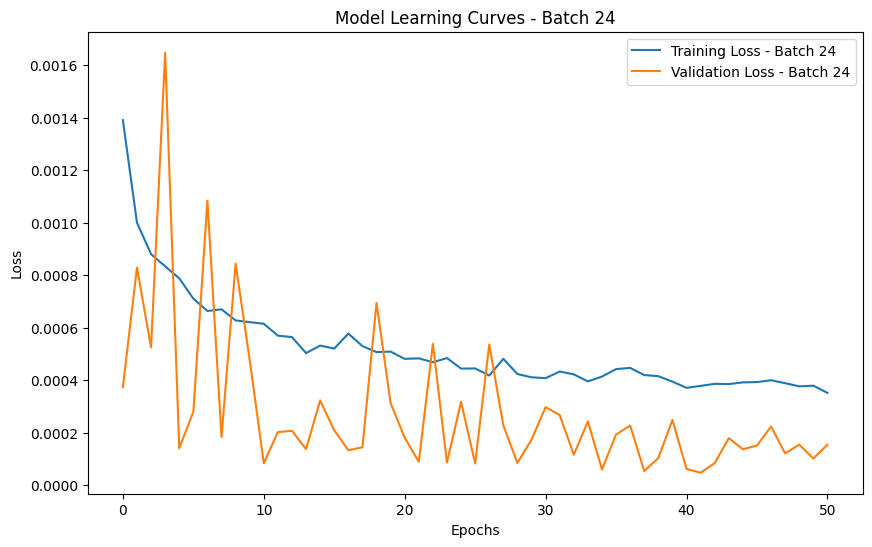

220/220 [==============================] - 2s 4ms/step
Results for batch size 24:
MAE: 0.013541253790118848
RMSE: 0.019339636999868817
R^2 Score: 0.9529213886382146

----------------------------------------

Training with batch size 32
Epoch 1/200
877/877 [==============================] - 16s 11ms/step - loss: 0.0012 - val_loss: 2.4732e-04
Epoch 2/200
877/877 [==============================] - 8s 9ms/step - loss: 8.4585e-04 - val_loss: 4.4199e-04
Epoch 3/200
877/877 [==============================] - 9s 10ms/step - loss: 7.6851e-04 - val_loss: 3.4196e-04
Epoch 4/200
877/877 [==============================] - 7s 9ms/step - loss: 7.5135e-04 - val_loss: 5.4527e-05
Epoch 5/200
877/877 [==============================] - 9s 10ms/step - loss: 6.4633e-04 - val_loss: 1.1418e-04
Epoch 6/200
877/877 [==============================] - 8s 9ms/step - loss: 5.8571e-04 - val_loss: 1.1316e-04
Epoch 7/200
877/877 [==============================] - 8s 9ms/step - loss: 6.0591e-04 - val_loss: 1.1734e-04
E

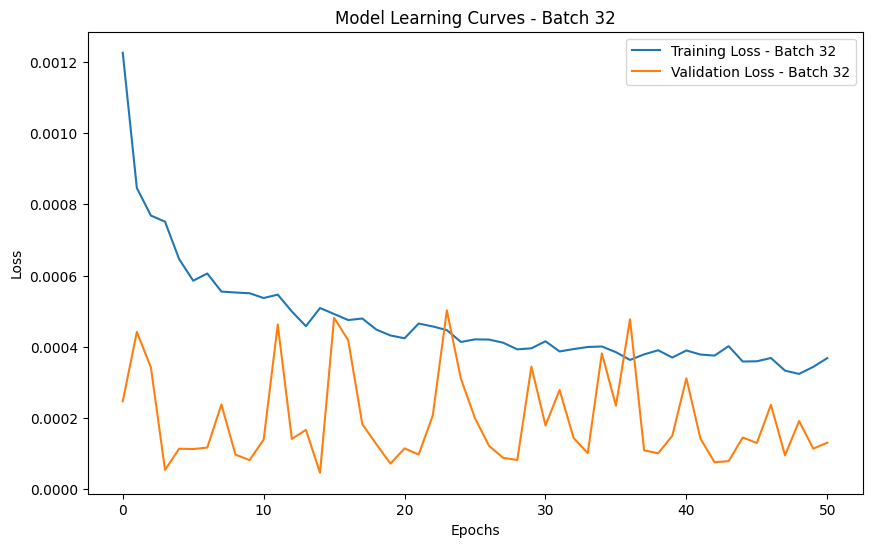

220/220 [==============================] - 1s 3ms/step
Results for batch size 32:
MAE: 0.010662392878045822
RMSE: 0.01572629374397941
R^2 Score: 0.9688699531229069

----------------------------------------

Training with batch size 64
Epoch 1/200
439/439 [==============================] - 12s 15ms/step - loss: 0.0010 - val_loss: 6.5493e-04
Epoch 2/200
439/439 [==============================] - 4s 9ms/step - loss: 6.6576e-04 - val_loss: 2.3962e-04
Epoch 3/200
439/439 [==============================] - 4s 10ms/step - loss: 5.3900e-04 - val_loss: 5.4384e-04
Epoch 4/200
439/439 [==============================] - 6s 13ms/step - loss: 5.5456e-04 - val_loss: 2.4736e-04
Epoch 5/200
439/439 [==============================] - 4s 9ms/step - loss: 4.9966e-04 - val_loss: 1.1850e-04
Epoch 6/200
439/439 [==============================] - 4s 9ms/step - loss: 5.2181e-04 - val_loss: 2.9313e-04
Epoch 7/200
439/439 [==============================] - 5s 12ms/step - loss: 4.8229e-04 - val_loss: 4.6743e-05
E

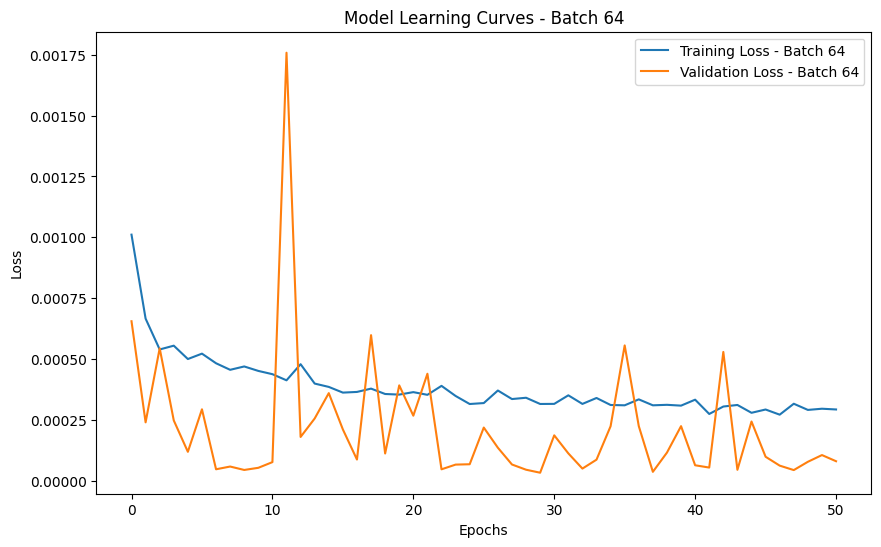

220/220 [==============================] - 1s 3ms/step
Results for batch size 64:
MAE: 0.01759179537700119
RMSE: 0.02559165259924741
R^2 Score: 0.9175627167091139

----------------------------------------

Training with batch size 128
Epoch 1/200
220/220 [==============================] - 10s 18ms/step - loss: 0.0010 - val_loss: 7.3757e-04
Epoch 2/200
220/220 [==============================] - 5s 21ms/step - loss: 5.0133e-04 - val_loss: 1.4859e-04
Epoch 3/200
220/220 [==============================] - 5s 23ms/step - loss: 4.8076e-04 - val_loss: 3.2407e-05
Epoch 4/200
220/220 [==============================] - 3s 14ms/step - loss: 4.5538e-04 - val_loss: 4.4980e-05
Epoch 5/200
220/220 [==============================] - 3s 14ms/step - loss: 3.7823e-04 - val_loss: 1.5995e-04
Epoch 6/200
220/220 [==============================] - 3s 14ms/step - loss: 3.7395e-04 - val_loss: 5.5695e-05
Epoch 7/200
220/220 [==============================] - 4s 19ms/step - loss: 3.0860e-04 - val_loss: 1.1628e-0

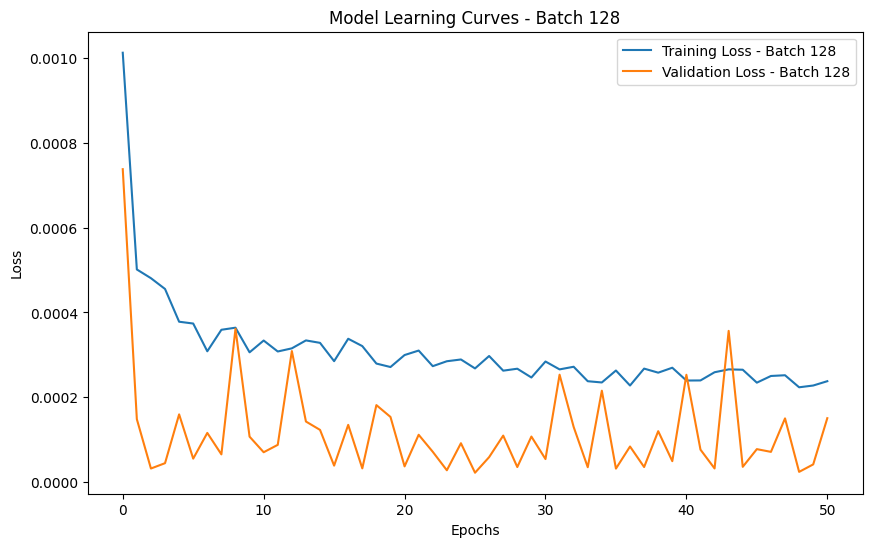

220/220 [==============================] - 2s 4ms/step
Results for batch size 128:
MAE: 0.02087688620956751
RMSE: 0.02715821880991588
R^2 Score: 0.9071611880945347

----------------------------------------



In [ ]:

#true model!!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define a function to create the model
def create_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', input_shape=(None, num_features)),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu'),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.3),
        Dense(1, activation='relu')
    ])
    return model

batch_sizes = [24, 32, 64, 128]
initial_learning_rate = 0.001

for batch_size in batch_sizes:
    print(f"Training with batch size {batch_size}")

    # Create a new model instance
    model = create_model()

    # Define the learning rate schedule and optimizer
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,  # Adjust if necessary
        decay_rate=0.96,
        staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, restore_best_weights=True)

    # Fit the model
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=200,
        batch_size=batch_size,
        validation_data=(X_test_reshaped, y_test),
        callbacks=[early_stopping],
        verbose=1  # Change to 1 if you want to see the progress for each epoch
    )

    # Plot learning curves
    plt.figure(figsize=(20, 6))
    plt.plot(history.history['loss'], label=f'Training Loss - Batch {batch_size}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Batch {batch_size}')
    plt.title(f'Model Learning Curves - Batch {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Generate predictions and calculate MAE, RMSE, R^2
    y_pred = model.predict(X_test_reshaped)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Results for batch size {batch_size}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R^2 Score: {r2}")
    print("\n" + "-"*40 + "\n")


In [ ]:
#lstm test
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.metrics import r2_score

def build_lstm_model(input_length, num_features):
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=(input_length, num_features)))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
batch_sizes = [24,32,64,128]
results = {}

for batch_size in batch_sizes:
    # Build and fit the LSTM model
    model = build_lstm_model(timesteps, num_features)
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=batch_size, validation_data=(X_test_reshaped, y_test))

    # Predictions
    y_pred = model.predict(X_test_reshaped)

    # Calculate MAE and RMSE
    mae = MeanAbsoluteError()
    rmse = RootMeanSquaredError()
    mae.update_state(y_test, y_pred)
    rmse.update_state(y_test, y_pred)

    # Calculate R^2
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[batch_size] = {'MAE': mae.result().numpy(), 'RMSE': rmse.result().numpy(), 'R2': r2}

# Print results
for batch_size, metrics in results.items():
    print(f"Batch Size: {batch_size}, MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}, R2: {metrics['R2']}")


Epoch 1/50
1169/1169 [==============================] - 18s 12ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 2/50
1169/1169 [==============================] - 13s 11ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 3/50
1169/1169 [==============================] - 13s 11ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 4/50
1169/1169 [==============================] - 13s 12ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 5/50
1169/1169 [==============================] - 13s 11ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 6/50
1169/1169 [==============================] - 12s 10ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 7/50
1169/1169 [==============================] - 13s 11ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 8/50
1169/1169 [==============================] - 13s 11ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 9/50
1169/1169 [==============================] - 13s 11ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/50
1169/1169 [==============================] - 13s 11m

In [ ]:
#cnn model test
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.metrics import r2_score

def build_cnn_model(num_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', input_shape=(None, num_features)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu'))
    model.add(GlobalAveragePooling1D())  # Pooling layer to reduce dimensionality
    model.add(Dropout(0.3))  # Dropout layer for regularization
    model.add(Dense(1, activation='relu'))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

batch_sizes = [24, 32, 64, 128]
results = {}

for batch_size in batch_sizes:
    # Build and fit the model
    model = build_cnn_model(num_features)
    history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=batch_size, validation_data=(X_test_reshaped, y_test))

    # Predictions
    y_pred = model.predict(X_test_reshaped)

    # Calculate MAE and RMSE
    mae = MeanAbsoluteError()
    rmse = RootMeanSquaredError()
    mae.update_state(y_test, y_pred)
    rmse.update_state(y_test, y_pred)

    # Calculate R^2
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[batch_size] = {'MAE': mae.result().numpy(), 'RMSE': rmse.result().numpy(), 'R2': r2}

# Print results
for batch_size, metrics in results.items():
    print(f"Batch Size: {batch_size}, MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}, R2: {metrics['R2']}")


Epoch 1/50
1169/1169 [==============================] - 9s 6ms/step - loss: 0.0096 - val_loss: 0.0011
Epoch 2/50
1169/1169 [==============================] - 5s 4ms/step - loss: 0.0020 - val_loss: 8.9411e-04
Epoch 3/50
1169/1169 [==============================] - 4s 4ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 4/50
1169/1169 [==============================] - 6s 5ms/step - loss: 0.0015 - val_loss: 2.5697e-04
Epoch 5/50
1169/1169 [==============================] - 4s 3ms/step - loss: 0.0015 - val_loss: 2.5130e-04
Epoch 6/50
1169/1169 [==============================] - 4s 4ms/step - loss: 0.0012 - val_loss: 3.4240e-04
Epoch 7/50
1169/1169 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/50
1169/1169 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 6.1474e-04
Epoch 9/50
1169/1169 [==============================] - 4s 3ms/step - loss: 0.0011 - val_loss: 6.6799e-04
Epoch 10/50
1169/1169 [==============================] - 5

In [ ]:
#summary cnn model
def build_cnn_model(num_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', input_shape=(None, num_features)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu'))
    model.add(GlobalAveragePooling1D())  # Pooling layer to reduce dimensionality
    model.add(Dropout(0.3))  # Dropout layer for regularization
    model.add(Dense(1, activation='relu'))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_2 = build_cnn_model(num_features)
model_2.summary()


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_89 (Conv1D)          (None, None, 64)          832       
                                                                 
 batch_normalization_50 (Ba  (None, None, 64)          256       
 tchNormalization)                                               
                                                                 
 conv1d_90 (Conv1D)          (None, None, 64)          12352     
                                                                 
 batch_normalization_51 (Ba  (None, None, 64)          256       
 tchNormalization)                                               
                                                                 
 conv1d_91 (Conv1D)          (None, None, 32)          6176      
                                                                 
 global_average_pooling1d_1  (None, 32)              

In [ ]:
#summary cnn_lstm_model
def build_cnn_lstm_model(num_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', input_shape=(None, num_features)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu'))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model_3 = build_cnn_lstm_model(num_features)

model_3.summary()


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_92 (Conv1D)          (None, None, 64)          832       
                                                                 
 batch_normalization_52 (Ba  (None, None, 64)          256       
 tchNormalization)                                               
                                                                 
 conv1d_93 (Conv1D)          (None, None, 64)          12352     
                                                                 
 batch_normalization_53 (Ba  (None, None, 64)          256       
 tchNormalization)                                               
                                                                 
 conv1d_94 (Conv1D)          (None, None, 32)          6176      
                                                                 
 lstm_20 (LSTM)              (None, None, 100)       

Training with batch size 32
Epoch 1/200
877/877 [==============================] - 15s 9ms/step - loss: 0.0013 - val_loss: 3.4710e-04
Epoch 2/200
877/877 [==============================] - 7s 8ms/step - loss: 8.3374e-04 - val_loss: 1.9766e-04
Epoch 3/200
877/877 [==============================] - 6s 7ms/step - loss: 6.9374e-04 - val_loss: 9.6263e-05
Epoch 4/200
877/877 [==============================] - 8s 9ms/step - loss: 6.6786e-04 - val_loss: 1.1632e-04
Epoch 5/200
877/877 [==============================] - 6s 7ms/step - loss: 6.4236e-04 - val_loss: 1.0612e-04
Epoch 6/200
877/877 [==============================] - 8s 9ms/step - loss: 6.2281e-04 - val_loss: 1.8633e-04
Epoch 7/200
877/877 [==============================] - 6s 7ms/step - loss: 5.7250e-04 - val_loss: 1.8065e-04
Epoch 8/200
877/877 [==============================] - 7s 8ms/step - loss: 6.2721e-04 - val_loss: 1.0988e-04
Epoch 9/200
877/877 [==============================] - 6s 7ms/step - loss: 5.7884e-04 - val_loss: 5.517

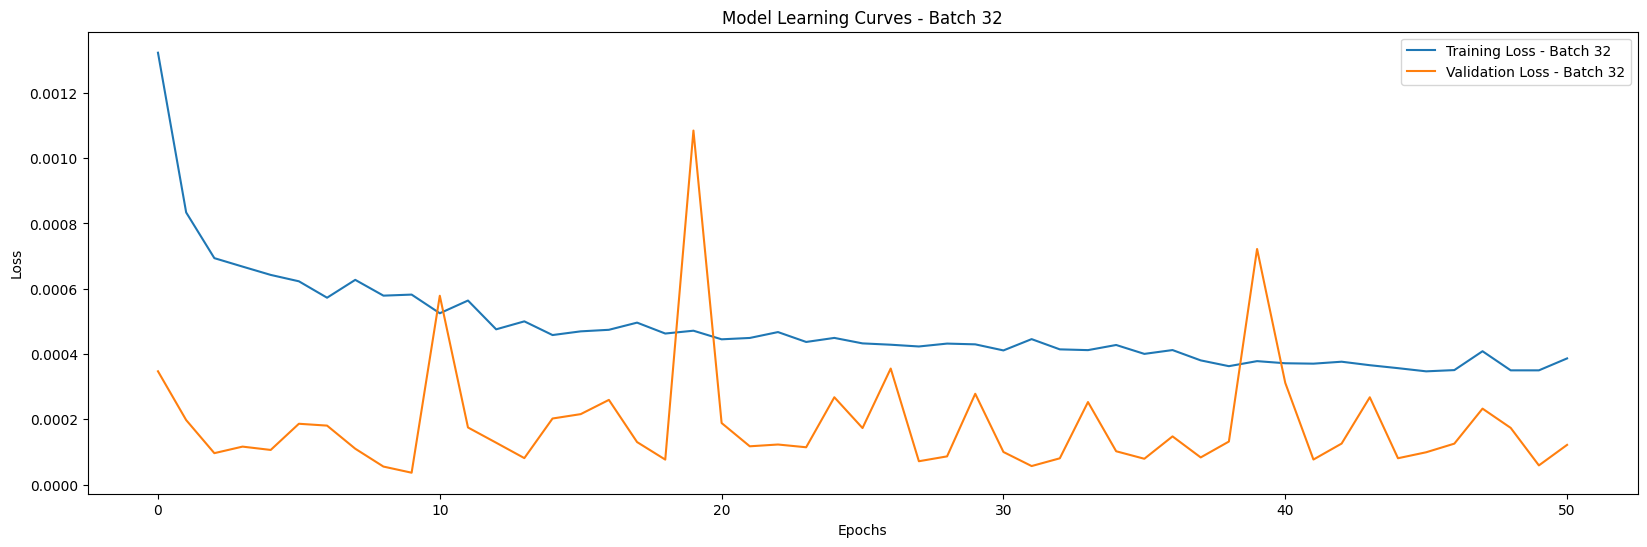

220/220 [==============================] - 1s 2ms/step
Results for batch size 32:
MAE: 0.01650152800005233
RMSE: 0.01863069511235501
R^2 Score: 0.9563096900821735


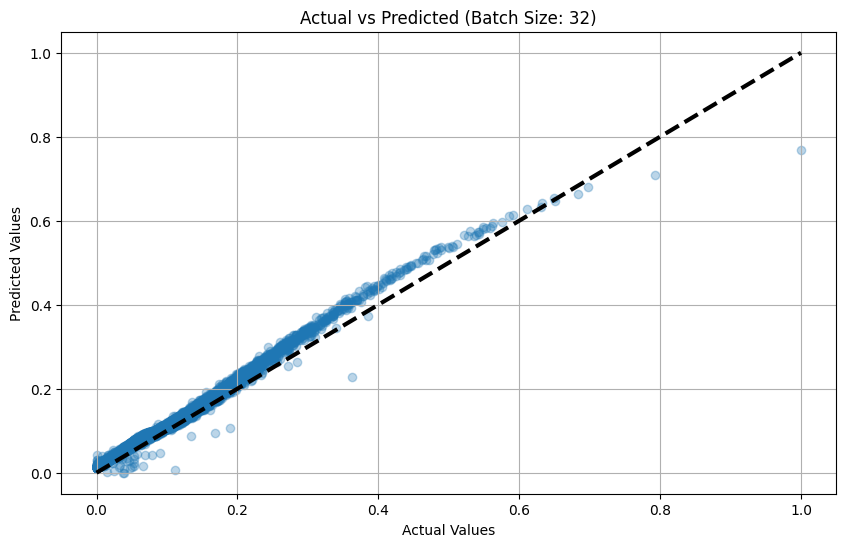

In [ ]:

#predict scatter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define a function to create the model
def create_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu', input_shape=(None, num_features)),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu'),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.3),
        Dense(1, activation='relu')
    ])
    return model

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=3)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

batch_sizes = [ 32]
initial_learning_rate = 0.001


for batch_size in batch_sizes:
    print(f"Training with batch size {batch_size}")

    # Create a new model instance
    model = create_model()

    # Define the learning rate schedule and optimizer
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,  # Adjust if necessary
        decay_rate=0.96,
        staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, restore_best_weights=True)

    # Fit the model
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=200,
        batch_size=batch_size,
        validation_data=(X_test_reshaped, y_test),
        callbacks=[early_stopping],
        verbose=1  # Change to 1 if you want to see the progress for each epoch
    )

    # Plot learning curves
    plt.figure(figsize=(20, 6))
    plt.plot(history.history['loss'], label=f'Training Loss - Batch {batch_size}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Batch {batch_size}')
    plt.title(f'Model Learning Curves - Batch {batch_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

        # Generate predictions
    y_pred = model.predict(X_test_reshaped)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Results for batch size {batch_size}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R^2 Score: {r2}")

    # Plot actual vs predicted values
    plot_actual_vs_predicted(y_test, y_pred.flatten(), title=f'Actual vs Predicted (Batch Size: {batch_size})')


    # print(f"Results for batch size {batch_size}:")
    # print(f"MAE: {mae}")
    # print(f"RMSE: {rmse}")
    # print(f"R^2 Score: {r2}")
    # print("\n" + "-"*40 + "\n")
